<font color='green' size=6 > Temperatura bajo escenarios de probabilidad

Elaborado por **Kevin Campos Sánchez**

Curso: Evaluación, vigilancia y estimación del riesgo climático

Ciclo académico 2023-I.

Universidad Nacional Agraria La Molina, Lima-Perú

### Preparación de entorno

* Shapefile - departamentos del Perú: https://www.geogpsperu.com/2019/08/limite-departamental-politico-shapefile.html

In [ ]:
import warnings # Omitir mensajes de advertencia
warnings.filterwarnings("ignore")

##### CONFIGURACIÓN DE ENTORNO #####
from google.colab import drive     # Conectar a Google drive
drive.mount('/content/drive/')

import os

path = '/content/drive/MyDrive/Trabajos_UNALM/EVERC/'  # Directorio de trabajo (cambiar aquí)
os.chdir(path)    # Establecer carpeta de trabajo

import numpy as np, pandas as pd, xarray as xr, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import norm    # Temperatura se ajusta a una distribución normal
from datetime import datetime

#%%capture
!pip install geopandas
!pip install cartopy
!pip install shapely --no-binary shapely --force
import geopandas as gpd

SHP = gpd.read_file(path + 'PISCO_monthly/DEPARTAMENTOS.zip')\
         .to_crs('EPSG:4326')

In [ ]:
#@title Prueba - temperatura bajo una probabilidad "prob"
# Nota: pdf <> pnorm    ppf <> qnorm
mean = 10   # Temperatura media
std = 7     # Desviación estándar

# 1. ¿Cuál es la temperatura con una probabilidad de 5%?
prob = 0.05
value = norm.ppf(prob, loc = mean, scale = std)
print(f'Una P = {prob:.2f} corresponde a una T = {value:.2f}')

# 2. ¿Cuál es la temperatura con una probabilidad de 13%?
prob = 0.13
value = norm.ppf(prob, loc = mean, scale = std)
print(f'Una P = {prob:.2f} corresponde a una T = {value:.2f}')

Una P = 0.05 corresponde a una T = -1.51
Una P = 0.13 corresponde a una T = 2.12


### Datos grillados: PISCOtn v1.1 a nivel mensual

Source: https://iridl.ldeo.columbia.edu/SOURCES/.SENAMHI/.HSR/.PISCO/

In [2]:
# Lectura de dataset
Tn = xr.open_dataarray(path + 'PISCO_monthly/PISCOtnm_1.1.nc', decode_times = False)
Tn['T'] = pd.date_range('1981-01-01','2016-12-31', freq = 'MS')
Tn

<xarray.DataArray 'tmin' (T: 432, Y: 202, X: 145)>
[12653280 values with dtype=float32]
Coordinates:
  * X        (X) float32 -81.45 -81.35 -81.25 -81.15 ... -67.25 -67.15 -67.05
  * T        (T) datetime64[ns] 1981-01-01 1981-02-01 ... 2016-11-01 2016-12-01
  * Y        (Y) float32 1.35 1.25 1.15 1.05 ... -18.45 -18.55 -18.65 -18.75
Attributes:
    long_name:       Minimum Temperature
    units:           Celsius_scale
    ncolor:          254
    colormap:        [null 7208960 7208960 8519680 [8519680 15] 11146260 [111...
    maxncolor:       254
    colorscalename:  temp_colors

In [7]:
Tn_clim = Tn.sel(T = slice('1981','2010')).groupby('T.month').mean()        # Media 1981-2010
Tn_std = Tn.sel(T = slice('1981','2010')).groupby('T.month').std(ddof = 1)  # Desv. Estándar

In [ ]:
prob_values = [0.25, 0.5, 0.75, 0.999]    # Escenarios de probabilidad

# Período de referencia para calcular medias y desviaciones
periods = [1981,2010]   # Período climatológico: 1981-2010

def prob_value_temp(da, p = 0.9):
    """ Devuelve el valor de T correspondiente al valor de probabilidad p """
    loc = np.mean(da)  
    scale = np.std(da, ddof = 1)
    return norm.ppf(p, loc, scale)

T_PROB = pd.DataFrame()     # DataFrame principal: valores de T bajo escenarios de probabilidad
p_name = lambda p: '100' if (p == 0.999) else int(p * 100)

for prob in prob_values:    # Por cada escenario...
    P = xr.Dataset()
    for month in range(1,12+1):     # Para cada mes...
        date_o = datetime(periods[0], month, 1)     # Inicio y fin del período de referencia
        date_f = datetime(periods[1], month, 1)
        P[month] = xr.apply_ufunc(prob_value_temp,  # Función (da, p)
                        Tn.sel(T = slice(date_o, date_f, 12)),   # da: dataarray
                        prob,                                    # p:  probabilidad
                        input_core_dims = [ ['T'], [] ],         # dimensión por argumento
                        vectorize = True)                        # Operación vectorizada

    P_df = P.to_dataframe().stack()     # Manipulación de los escenarios mensuales como DataFrame
    P_df.name = f'{p_name(prob)}%'

    T_PROB = pd.concat([T_PROB, P_df], axis = 1)    # Unir valores de T al DataFrame general

# Nombrar y ordenar coordenadas (lat, lon, mes)
T_PROB.index = T_PROB.index.set_names(['X','Y','month']).reorder_levels(['Y','X','month'])
T_xr = T_PROB.to_xarray()   # pandas.DataFrame --> xarray.DataSet
T_xr.to_netcdf(path + 'PISCO_monthly/T_prob.nc')

In [ ]:
T_xr

<xarray.Dataset>
Dimensions:  (Y: 202, X: 145, month: 12)
Coordinates:
  * Y        (Y) float64 1.35 1.25 1.15 1.05 ... -18.45 -18.55 -18.65 -18.75
  * X        (X) float64 -81.45 -81.35 -81.25 -81.15 ... -67.25 -67.15 -67.05
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    25%      (Y, X, month) float64 nan nan nan nan ... 0.8928 1.894 4.142
    50%      (Y, X, month) float64 nan nan nan nan ... 0.3781 1.43 2.787 4.586
    75%      (Y, X, month) float64 nan nan nan nan ... 1.107 1.966 3.681 5.031
    100%     (Y, X, month) float64 nan nan nan nan nan ... 3.72 3.889 6.88 6.622

### Visualización de resultados

In [6]:
import matplotlib.ticker as mticker, cartopy.crs as ccrs
from cartopy.feature import BORDERS, OCEAN, LAND
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

path_plot = path + 'T_prob/'
shp_dict = dict(edgecolor='black', linewidth = 0.35, zorder = 1)

cmap = plt.get_cmap('RdBu_r', 14)
cmap.set_bad('#EBEBEB')

MES = {1:'ENERO', 2:'FEBRERO', 3:'MARZO', 4:'ABRIL', 5:'MAYO', 6:'JUNIO',
       7:'JULIO',8:'AGOSTO',9:'SETIEMBRE',10:'OCTUBRE',11:'NOVIEMBRE',12:'DICIEMBRE'}

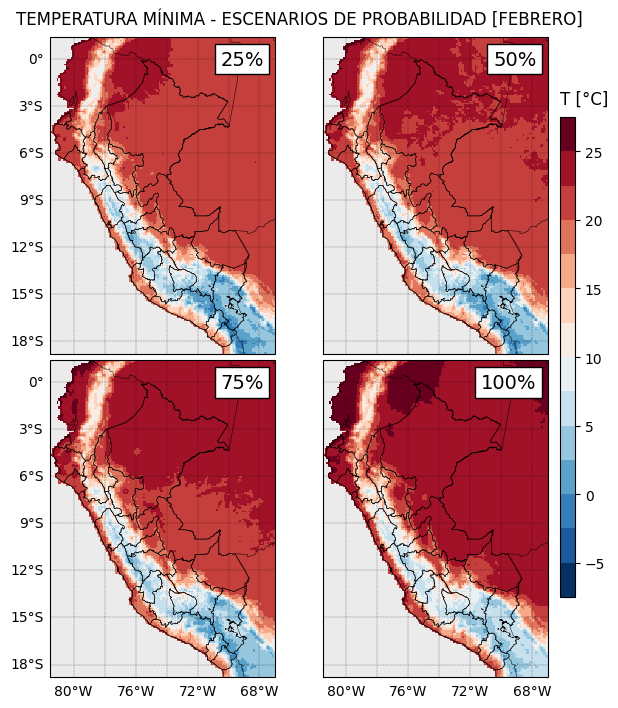

In [ ]:
m = 2   # 2 = feb, 7 = jul

#######################################################################
fig, Ax = plt.subplots(2,2, figsize = (6,8), 
                       subplot_kw = {'projection':ccrs.PlateCarree()})
props = dict(facecolor='white', alpha=1)

for i, ax, p in zip(range(4), Ax.flatten(), [f'{p_name(p)}%' for p in prob_values]):
    plot = T_xr[p].sel(month = m).plot(ax = ax, add_colorbar = False,
                                cmap = cmap, vmin = -7.5, vmax = 27.5)

    # Título
    ax.set_title('')
    ax.text(0.95, 0.90, p, transform=ax.transAxes, fontsize=14,
        verticalalignment='bottom', horizontalalignment = 'right', bbox=props)

    grids = ax.gridlines(color='black', alpha=0.5, linestyle='--', linewidth = 0.35,
                        crs = ccrs.PlateCarree(), draw_labels = True)

    # Desactivar labels innecesarios
    grids.xlabels_top = False; grids.ylabels_right = False   
    if i in [1, 3]:  grids.ylabels_left = False
    if i in [0, 1]:  grids.xlabels_bottom = False

    # Límites geopolíticos
    ax.add_feature(BORDERS, color='black', lw = 0.35, zorder = 1)
    ax.coastlines('50m', linewidth = 0.35)
    SHP.boundary.plot(ax = ax, **shp_dict)

# Barra de colores
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.935, 0.2, 0.025, 0.6])
fig.colorbar(plot, cax=cbar_ax)
cbar_ax.set_title('T [°C]', loc = 'left', y = 1.01)


plt.suptitle(f'TEMPERATURA MÍNIMA - ESCENARIOS DE PROBABILIDAD [{MES[m]}]', y = 0.935, x = 0.5)
plt.subplots_adjust(bottom = 0.1, top = 0.9, left = 0.05, right = 0.95, wspace = 0.02, hspace = 0.02)

fig.savefig(path_plot + f'Tn_prob_{MES[m]}.png', 
            transparent = False, pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')

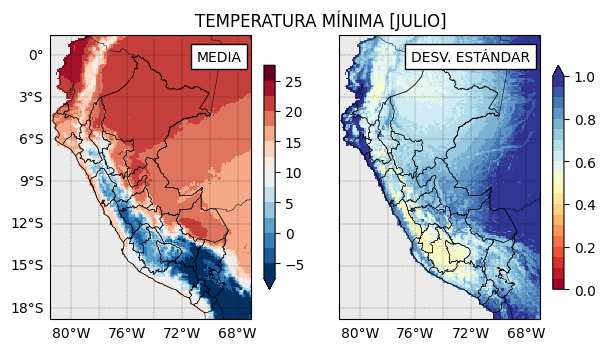

In [8]:
m = 7   # 2 = feb, 7 = jul

cmap2 = plt.get_cmap('RdYlBu', 20)
cmap2.set_bad('#EBEBEB')

#######################################################################
fig, Ax = plt.subplots(1,2, figsize = (6,4), 
                       subplot_kw = {'projection':ccrs.PlateCarree()})
props = dict(facecolor='white', alpha=1)

plot_1 = Tn_clim.sel(month = m).plot(ax = Ax[0], add_colorbar = True,
                                    cmap = cmap, vmin = -7.5, vmax = 27.5,
                                    cbar_kwargs={'pad':0.05, 'shrink':0.7, 'label':''})
plot_2 = Tn_std.sel(month = m).plot(ax = Ax[1], add_colorbar = True,
                                    cmap = cmap2, vmin = 0, vmax = 1,
                                    cbar_kwargs={'pad':0.05, 'shrink':0.7, 'label':''})

for i, ax, p in zip(range(2), Ax.flatten(), ['MEDIA', 'DESV. ESTÁNDAR']):
    ax.set_title('')    # Título
    ax.text(0.95, 0.90, p, transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', horizontalalignment = 'right', bbox=props)

    grids = ax.gridlines(color='black', alpha=0.5, linestyle='--', linewidth = 0.35,
                        crs = ccrs.PlateCarree(), draw_labels = True)

    # Desactivar labels innecesarios
    grids.xlabels_top = False; grids.ylabels_right = False   
    if i == 1:  grids.ylabels_left = False

    # Límites geopolíticos
    ax.add_feature(BORDERS, color='black', lw = 0.35, zorder = 1)
    ax.coastlines('50m', linewidth = 0.35)
    SHP.boundary.plot(ax = ax, **shp_dict)

plt.suptitle(f'TEMPERATURA MÍNIMA [{MES[m]}]', y = 0.92, x = 0.5)
plt.subplots_adjust(bottom = 0.1, top = 0.9, left = 0.05, right = 0.95, wspace = 0.15, hspace = 0.02)

fig.savefig(path_plot + f'Tn_{MES[m]}.png', 
            transparent = False, pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')

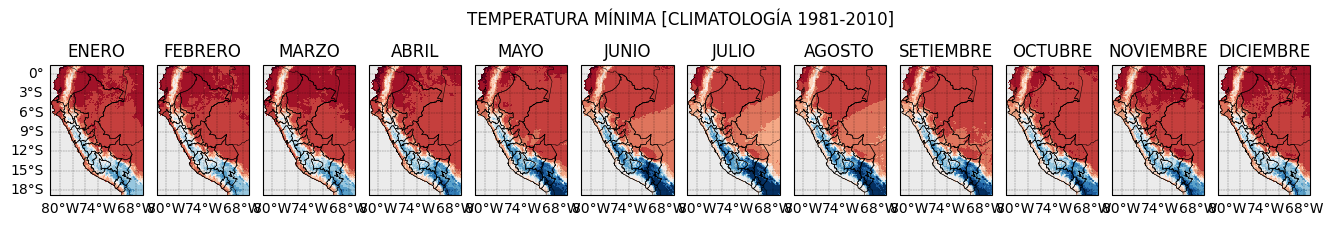

In [26]:
cmap2 = plt.get_cmap('RdYlBu', 20)
cmap2.set_bad('#EBEBEB')

#######################################################################
plot = Tn_clim.plot(x='X', y='Y', col='month', col_wrap=12, figsize = (14,3), 
                      add_colorbar = False, subplot_kws = {"projection": ccrs.PlateCarree()},
                      cmap = cmap, vmin = -7.5, vmax = 27.5,
                      cbar_kwargs={'pad':0.01, 'shrink':0.5, 'label':''})

for i, ax, m in zip(range(12), plot.axes.flatten(), list(MES.values())):
    ax.set_title(m)    # Título
    grids = ax.gridlines(color='black', alpha=0.5, linestyle='--', linewidth = 0.35,
                        crs = ccrs.PlateCarree(), draw_labels = True)

    # Desactivar labels innecesarios
    grids.xlabels_top = False; grids.ylabels_right = False   
    if i != 0:  grids.ylabels_left = False

    # Límites geopolíticos
    ax.add_feature(BORDERS, color='black', lw = 0.35, zorder = 1)
    ax.coastlines('50m', linewidth = 0.35)
    SHP.boundary.plot(ax = ax, **shp_dict)

plt.suptitle(f'TEMPERATURA MÍNIMA [CLIMATOLOGÍA 1981-2010]', y = 0.9, x = 0.5)
plt.subplots_adjust(bottom = 0.1, top = 0.9, left = 0.05, right = 0.95, wspace = 0.15, hspace = 0.02)

plot.fig.savefig(path_plot + f'Tn_CLIM.png', 
                 transparent = False, pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')

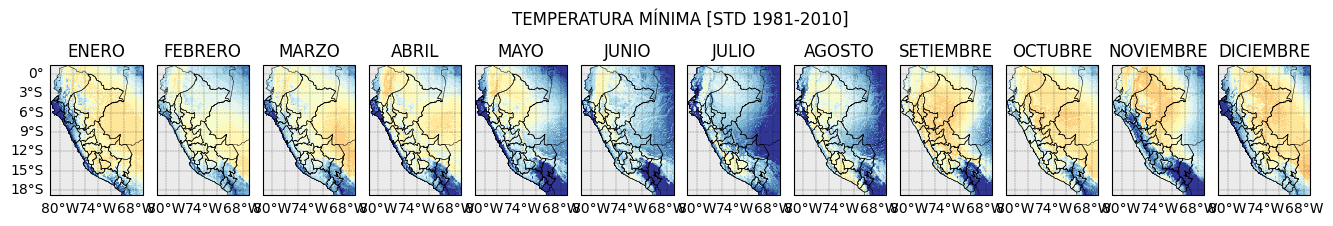

In [27]:
cmap2 = plt.get_cmap('RdYlBu', 20)
cmap2.set_bad('#EBEBEB')

#######################################################################
plot = Tn_std.plot(x='X', y='Y', col='month', col_wrap=12, figsize = (14,3), 
                      add_colorbar = False, subplot_kws = {"projection": ccrs.PlateCarree()},
                      cmap = cmap2, vmin = 0, vmax = 1,
                      cbar_kwargs={'pad':0.01, 'shrink':0.5, 'label':''})

for i, ax, m in zip(range(12), plot.axes.flatten(), list(MES.values())):
    ax.set_title(m)    # Título
    grids = ax.gridlines(color='black', alpha=0.5, linestyle='--', linewidth = 0.35,
                        crs = ccrs.PlateCarree(), draw_labels = True)

    # Desactivar labels innecesarios
    grids.xlabels_top = False; grids.ylabels_right = False   
    if i != 0:  grids.ylabels_left = False

    # Límites geopolíticos
    ax.add_feature(BORDERS, color='black', lw = 0.35, zorder = 1)
    ax.coastlines('50m', linewidth = 0.35)
    SHP.boundary.plot(ax = ax, **shp_dict)

plt.suptitle(f'TEMPERATURA MÍNIMA [STD 1981-2010]', y = 0.9, x = 0.5)
plt.subplots_adjust(bottom = 0.1, top = 0.9, left = 0.05, right = 0.95, wspace = 0.15, hspace = 0.02)

plot.fig.savefig(path_plot + f'Tn_STD.png', 
                 transparent = False, pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')